### Imports

In [1]:
# Libraries
import os
from importlib import reload
import tensorflow as tf
import keras

import numpy as np
import matplotlib.pyplot as plt

# Scripts
from helpers import data, runners, utils, generators

In [2]:
# Should be v2.10
!pip show tensorflow 

Name: tensorflow
Version: 2.10.1
Summary: TensorFlow is an open source machine learning framework for everyone.
Home-page: https://www.tensorflow.org/
Author: Google Inc.
Author-email: packages@tensorflow.org
License: Apache 2.0
Location: c:\users\sonar\anaconda3v2\envs\acml_2024\lib\site-packages
Requires: absl-py, astunparse, flatbuffers, gast, google-pasta, grpcio, h5py, keras, keras-preprocessing, libclang, numpy, opt-einsum, packaging, protobuf, setuptools, six, tensorboard, tensorflow-estimator, tensorflow-io-gcs-filesystem, termcolor, typing-extensions, wrapt
Required-by: 


In [3]:
# Should be v2.10
!pip show keras

Name: keras
Version: 2.10.0
Summary: Deep learning for humans.
Home-page: https://keras.io/
Author: Keras team
Author-email: keras-users@googlegroups.com
License: Apache 2.0
Location: c:\users\sonar\anaconda3v2\envs\acml_2024\lib\site-packages
Requires: 
Required-by: keras-tuner, tensorflow


In [4]:
reload(runners)
reload(data)
reload(utils)

<module 'helpers.utils' from 'c:\\Users\\sonar\\Desktop\\thesis-ml\\ml\\main\\helpers\\utils.py'>

In [5]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1'

# Check whether tf is using the GPU
utils.check_gpu_use() 

GPU DETECTED ✓
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


## `main`

### Load data

In [6]:
N_FOLDS = 10
DATA_BATCH_SIZE = 16
GPU_BATCH_SIZE = 8
EPOCHS = 20


In [7]:
fold_dfs = data.get_fold_dfs(
    fold_definition_csv="../data/DATASET_CSVS/deepship_5k_seg_3s.csv",
    new_path_to_root="../data/deepship_baseline_mat",
    ext="mat", 
    n_folds=N_FOLDS,
    unix=False
)

In [8]:
train_df, test_df = data.generate_kth_fold(fold_dfs, test_idx=0, val_idx=None)

print(train_df.shape)
print(test_df.shape)

del fold_dfs

(48968, 5)
(4534, 5)


In [9]:
train_gen = generators.DeepShipGenerator(
    train_df,
    ext="mat",
    mat_var_name="Pexp",
    batch_size=DATA_BATCH_SIZE,
    shuffle=True,
    X_only=True
)

test_gen = generators.DeepShipGenerator(
    test_df,
    ext="mat",
    mat_var_name="Pexp",
    batch_size=DATA_BATCH_SIZE,
    shuffle=False,
    X_only=True
)

### Initialise model

In [10]:
def psnr(y_true, y_pred):
    return tf.image.psnr(y_true, y_pred, max_val=1.0)

# Learning rate decay
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-3,
    decay_steps=1000, 
    decay_rate=0.9 
)

In [11]:
from models import sae
reload(sae)

model = sae.get_sae_model(input_shape=(192, 192, 1), sparsity_coefficient=1e-5)

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=lr_schedule),
    loss=keras.losses.MeanSquaredError(),
    metrics=[psnr]
)

model.summary()

Model: "sparse_autoencoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_input (InputLayer)  [(None, 192, 192, 1)]     0         
                                                                 
 flatten (Flatten)           (None, 36864)             0         
                                                                 
 dense (Dense)               (None, 256)               9437440   
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                                 
 dense_2 (Dense)             (None, 64)                8256      
                                                                 
 bottleneck (Dense)          (None, 32)                2080      
                                                                 
 dense_3 (Dense)             (None, 64)         

### Train model

In [12]:
history = model.fit(
    train_gen,
    batch_size=GPU_BATCH_SIZE,
    epochs=EPOCHS,
    verbose=2
)

Epoch 1/20
3060/3060 - 97s - loss: 0.0241 - psnr: 16.5379 - 97s/epoch - 32ms/step
Epoch 2/20
3060/3060 - 95s - loss: 0.0239 - psnr: 16.5621 - 95s/epoch - 31ms/step
Epoch 3/20
3060/3060 - 95s - loss: 0.0239 - psnr: 16.5640 - 95s/epoch - 31ms/step
Epoch 4/20
3060/3060 - 99s - loss: 0.0239 - psnr: 16.5655 - 99s/epoch - 32ms/step
Epoch 5/20
3060/3060 - 94s - loss: 0.0239 - psnr: 16.5663 - 94s/epoch - 31ms/step
Epoch 6/20
3060/3060 - 94s - loss: 0.0239 - psnr: 16.5667 - 94s/epoch - 31ms/step
Epoch 7/20
3060/3060 - 94s - loss: 0.0239 - psnr: 16.5666 - 94s/epoch - 31ms/step
Epoch 8/20
3060/3060 - 96s - loss: 0.0239 - psnr: 16.5671 - 96s/epoch - 31ms/step
Epoch 9/20
3060/3060 - 94s - loss: 0.0239 - psnr: 16.5672 - 94s/epoch - 31ms/step
Epoch 10/20
3060/3060 - 94s - loss: 0.0239 - psnr: 16.5674 - 94s/epoch - 31ms/step
Epoch 11/20
3060/3060 - 96s - loss: 0.0239 - psnr: 16.5674 - 96s/epoch - 31ms/step
Epoch 12/20
3060/3060 - 95s - loss: 0.0239 - psnr: 16.5673 - 95s/epoch - 31ms/step
Epoch 13/20
3

In [13]:
evals = model.evaluate(
    test_gen,
    batch_size=GPU_BATCH_SIZE,
    verbose=2
)

283/283 - 33s - loss: 0.0250 - psnr: 16.3454 - 33s/epoch - 117ms/step


In [14]:
model.save("models/saved/sae_denoiser_11112024/sae_denoiser_100_epochs.keras")

### Evaluation, metrics, and visualising denoised output

C:\Users\sonar\AppData\Local\Temp\ipykernel_27424\2440722451.py:4: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


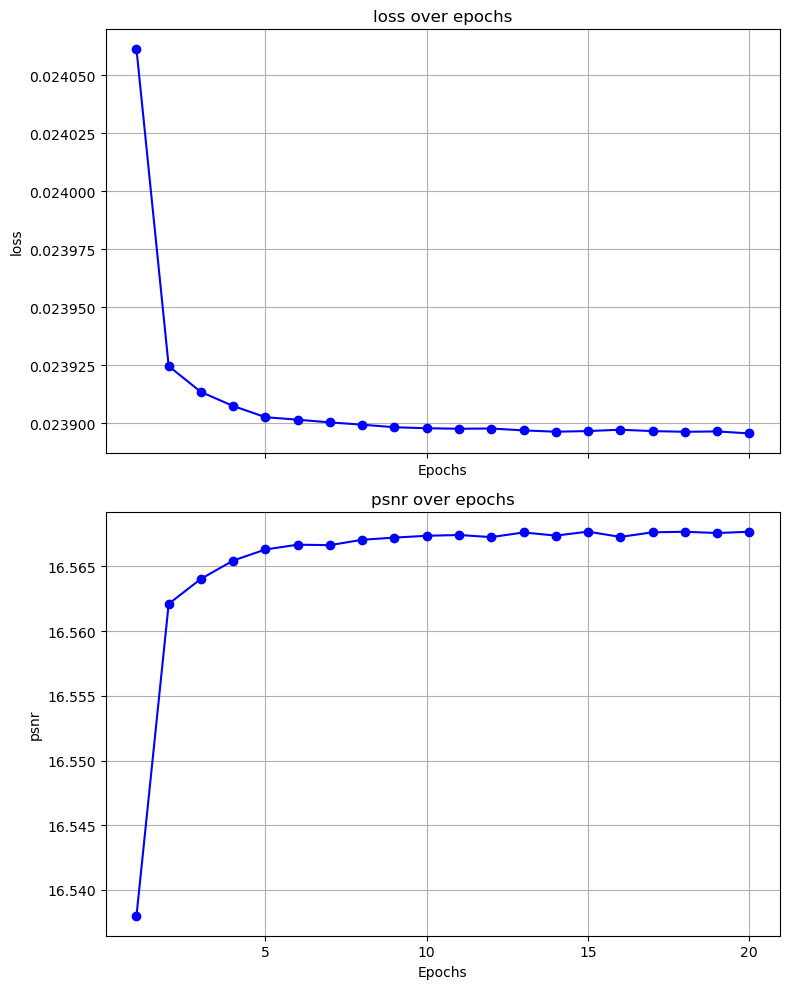

In [15]:
reload(utils)
fig = utils.get_history_curve(history, metrics=['loss', 'psnr'])
fig.savefig("models/saved/sae_denoiser_11112024/sae_denoiser_100_epochs.pdf")
fig.show()

In [16]:
# Get a few samples from the test generator for visualisation and metrics calculation
num_samples = 5 

sample_batch = next(iter(test_gen))[0]
sample_inputs = sample_batch[:num_samples]  # Extract the first `num_samples` examples from the batch

# Predict the denoised outputs
denoised_outputs = model.predict(sample_inputs)

1/1 [==============================] - 0s 129ms/step


In [17]:
# Get evaluation metrics
mse_score = tf.keras.losses.MeanSquaredError()(sample_inputs, denoised_outputs).numpy()
psnr_score = psnr(sample_inputs, denoised_outputs).numpy()

print(f"MSE on sample batch: {mse_score}")
print(f"PSNR on sample batch: {psnr_score}")

MSE on sample batch: 0.02290911227464676
PSNR on sample batch: [14.441526 18.061964 15.880528 16.250408 18.719917]


In [18]:
# Check if all outputs are normalised
for i, output in enumerate(denoised_outputs):
    print(f"Sample {i+1} - Min: {np.min(output)}; Max: {np.max(output)}")

Sample 1 - Min: 0.3816893994808197; Max: 0.7676812410354614
Sample 2 - Min: 0.3816893994808197; Max: 0.7676812410354614
Sample 3 - Min: 0.3816893994808197; Max: 0.7676812410354614
Sample 4 - Min: 0.3816893994808197; Max: 0.7676812410354614
Sample 5 - Min: 0.3816893994808197; Max: 0.7676812410354614


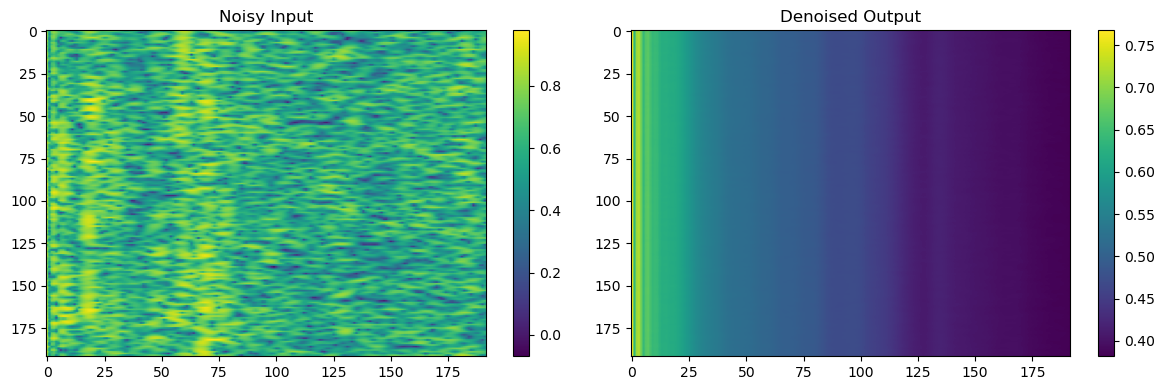

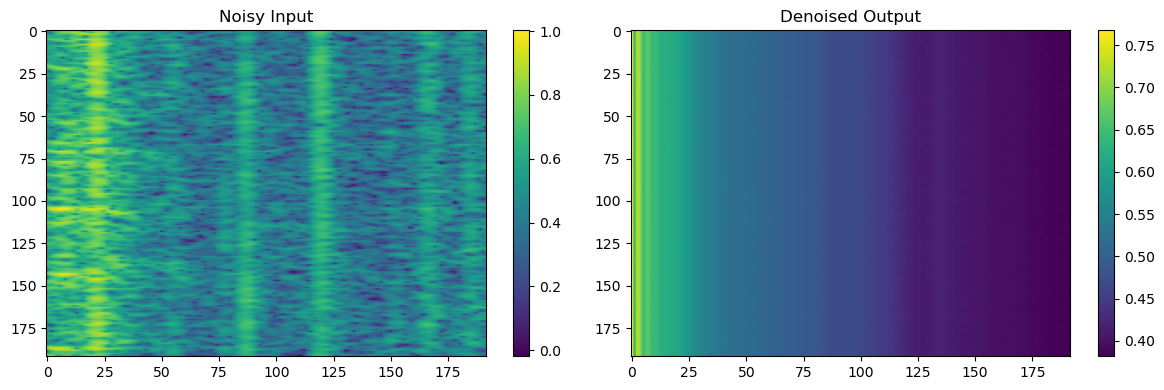

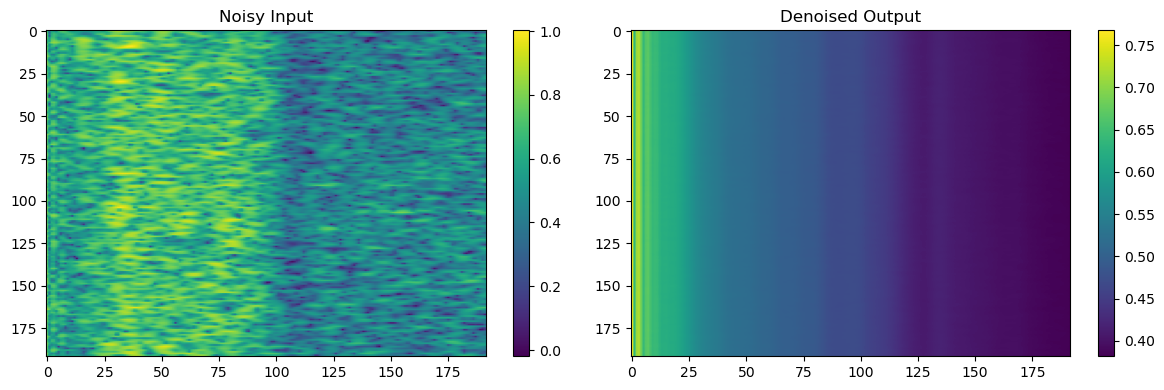

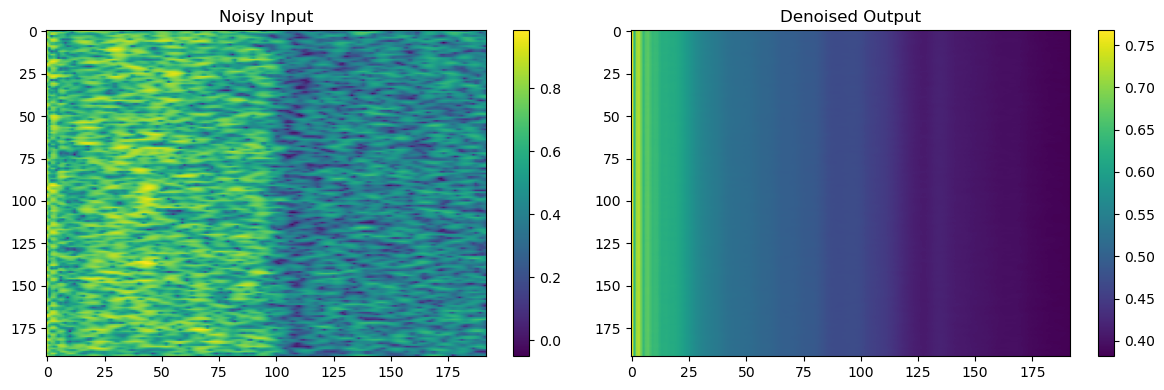

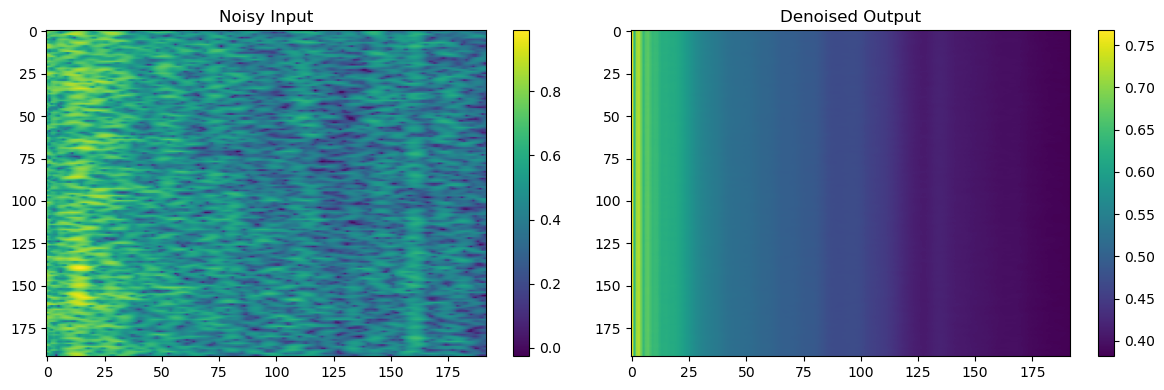

In [19]:
# Plot the input, output, and target spectrograms for each sample
for i in range(num_samples):
    fig = plt.figure(figsize=(12, 4))
    
    # Noisy Input
    plt.subplot(1, 2, 1)
    plt.imshow(sample_inputs[i].squeeze(), cmap="viridis", aspect="auto")
    plt.title("Noisy Input")
    plt.colorbar()

    # Denoised Output
    plt.subplot(1, 2, 2)
    plt.imshow(denoised_outputs[i].squeeze(), cmap="viridis", aspect="auto")
    plt.title("Denoised Output")
    plt.colorbar()

    plt.tight_layout()
    plt.show()

    # fig.savefig(f"models/img/irfan_denoise/ex{i + 1}.png")